In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from tslearn.metrics import dtw_path
import matplotlib.animation as animation
import stumpy
import cv2
import re
import datetime

In [2]:
#################
# Data Cleaning #
#################

# Change path to dataset
alldf1 = pd.read_csv('/Users/maxingjian/Desktop/Eye tracking data analysis/combined data/IDBY01.csv')
alldf2 = pd.read_csv('/Users/maxingjian/Desktop/Eye tracking data analysis/combined data/IDBY21.csv')


alldf1['rec_time_s'] =  pd.to_datetime(alldf1['rec_time'], format="%H:%M:%S.%f")
alldf1['rec_time_s'] = alldf1['rec_time_s'] - pd.to_datetime("1900-01-01", format="%Y-%m-%d")
alldf1['rec_time_s'] =  (alldf1['rec_time_s']).dt.total_seconds()
alldf1['rec_time_s'] = alldf1['rec_time_s'].interpolate(limit_direction = 'both')
alldf1['Simulator_XPosition'] = alldf1['Simulator_XPosition'].interpolate(limit_direction = 'both')


alldf2['rec_time_s'] =  pd.to_datetime(alldf2['rec_time'], format="%H:%M:%S.%f")
alldf2['rec_time_s'] = alldf2['rec_time_s'] - pd.to_datetime("1900-01-01", format="%Y-%m-%d")
alldf2['rec_time_s'] =  (alldf2['rec_time_s']).dt.total_seconds()
alldf2['rec_time_s'] = alldf2['rec_time_s'].interpolate(limit_direction = 'both')
alldf2['Simulator_XPosition'] = alldf2['Simulator_XPosition'].interpolate(limit_direction = 'both')

cols = ['TobiiPro.Glasses.2_Eye.Data_Original.Data_Left.Eye_Pupil.X',
        'TobiiPro.Glasses.2_Eye.Data_Original.Data_Left.Eye_Pupil.Y',
        'TobiiPro.Glasses.2_Eye.Data_Original.Data_Left.Eye_Pupil.Z',
        'TobiiPro.Glasses.2_Eye.Data_Original.Data_Left.Eye_Gaze.Direction_Gaze.Direction.X',
        'TobiiPro.Glasses.2_Eye.Data_Original.Data_Left.Eye_Gaze.Direction_Gaze.Direction.Y',
        'TobiiPro.Glasses.2_Eye.Data_Original.Data_Left.Eye_Gaze.Direction_Gaze.Direction.Z',
        'TobiiPro.Glasses.2_Eye.Data_Original.Data_Right.Eye_Pupil.X',
        'TobiiPro.Glasses.2_Eye.Data_Original.Data_Right.Eye_Pupil.Y',	
        'TobiiPro.Glasses.2_Eye.Data_Original.Data_Right.Eye_Pupil.Z',
        'TobiiPro.Glasses.2_Eye.Data_Original.Data_Right.Eye_Gaze.Direction_Gaze.Direction.X',
        'TobiiPro.Glasses.2_Eye.Data_Original.Data_Right.Eye_Gaze.Direction_Gaze.Direction.Y',
        'TobiiPro.Glasses.2_Eye.Data_Original.Data_Right.Eye_Gaze.Direction_Gaze.Direction.Z',
        'TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position.3D_Gaze.X',
        'TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position.3D_Gaze.Y',
        'TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position.3D_Gaze.Z',
        'TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.X',
        'TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.Y']

for i in np.arange(len(cols)):
    alldf1.loc[alldf1[cols[i]]==0,cols[i]] = np.nan
for i in np.arange(len(cols)):
    alldf2.loc[alldf2[cols[i]]==0,cols[i]] = np.nan 

alldf1[cols] = alldf1[cols].interpolate(limit_direction = 'both')
alldf1[cols].isna().sum().sum()
alldf2[cols] = alldf2[cols].interpolate(limit_direction = 'both')
alldf2[cols].isna().sum().sum()

0

In [3]:
# normalization

def normalize_scan_path(scan_path):
    
    min_val = np.min(scan_path, axis=0)
    max_val = np.max(scan_path, axis=0)
    mean_val = np.mean(scan_path, axis=0)

    normalized_scan_path = scan_path - mean_val

    return normalized_scan_path



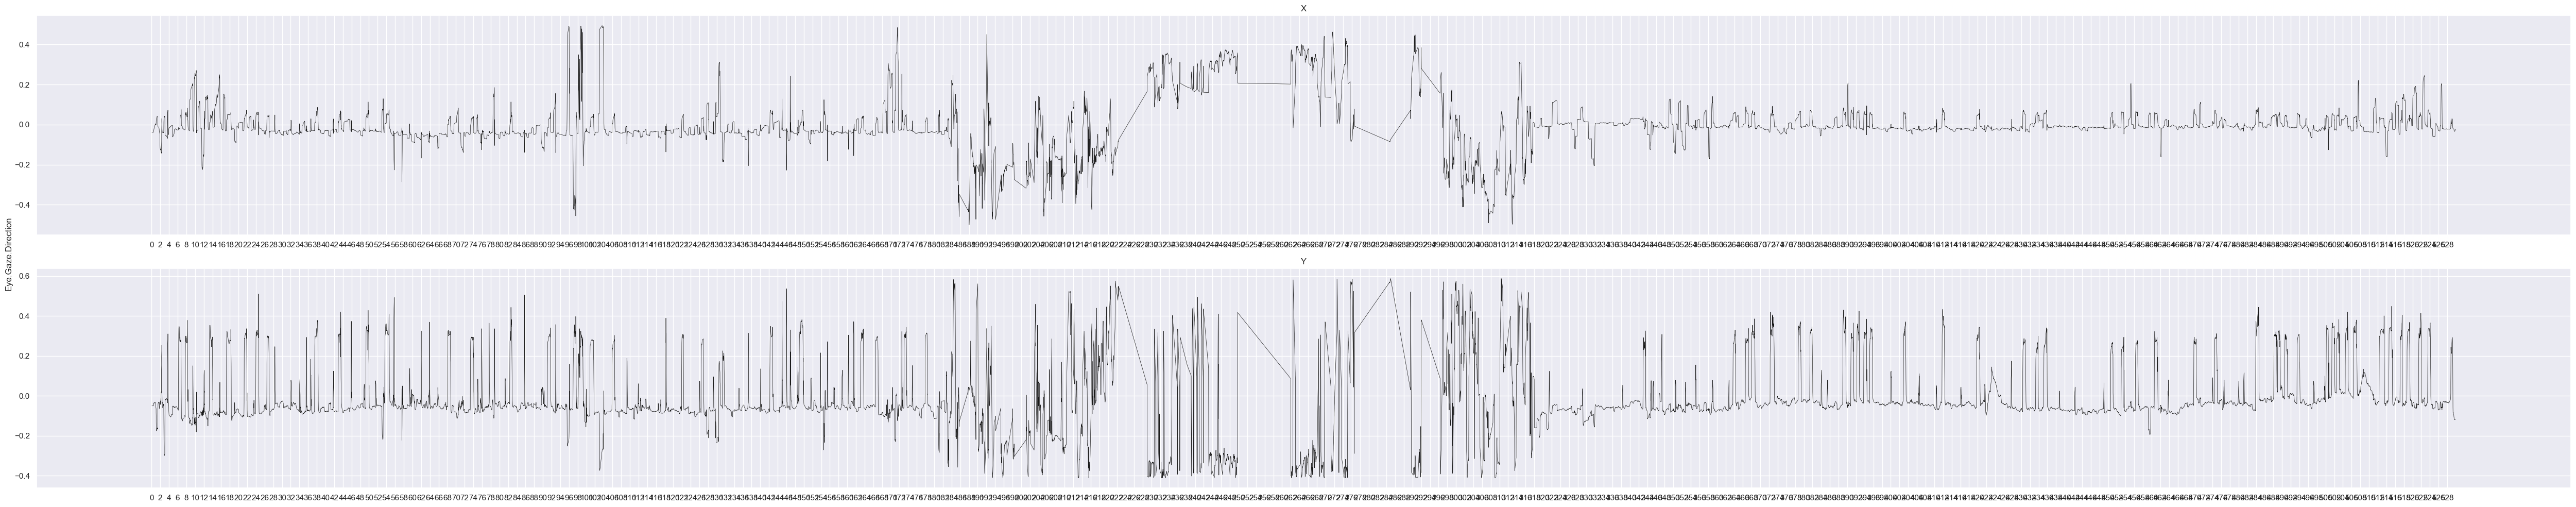

In [4]:
############################
# Visualization of X and Y #
############################


tempdf1 = alldf1[(alldf1.Subject == 'IDBY01') & (alldf1.Drive == 'Drive1')]
tempdf2 = alldf2[(alldf2.Subject == 'IDBY21') & (alldf2.Drive == 'Drive1')]

filtered_columns1 = tempdf1.filter(regex='^(TobiiPro\.Glasses\.2_Field\.Data_Scene\.Cam_Original\.Data_Front\.Shield\.|TobiiPro\.Glasses\.2_Field\.Data_Scene\.Cam_Original\.Data_Dashboard\.|TobiiPro\.Glasses\.2_Field\.Data_Scene\.Cam_Original\.Data_Rearview\.Mirror\.|TobiiPro\.Glasses\.2_Field\.Data_Scene\.Cam_Original\.Data_Left\.Side\.Mirror\.|TobiiPro\.Glasses\.2_Field\.Data_Scene\.Cam_Original\.Data_Right\.Side\.Mirror\.)', axis=1)
filtered_columns2 = tempdf2.filter(regex='^(TobiiPro\.Glasses\.2_Field\.Data_Scene\.Cam_Original\.Data_Front\.Shield\.|TobiiPro\.Glasses\.2_Field\.Data_Scene\.Cam_Original\.Data_Dashboard\.|TobiiPro\.Glasses\.2_Field\.Data_Scene\.Cam_Original\.Data_Rearview\.Mirror\.|TobiiPro\.Glasses\.2_Field\.Data_Scene\.Cam_Original\.Data_Left\.Side\.Mirror\.|TobiiPro\.Glasses\.2_Field\.Data_Scene\.Cam_Original\.Data_Right\.Side\.Mirror\.)', axis=1)

# Generate a new dictionary of column names
new_column_names1 = {}
for column_name in filtered_columns1.columns:
    new_column_name = re.sub(r'\.\d+$', '', column_name)  # Removing the last digit
    new_column_names1[column_name] = new_column_name
    
new_column_names2 = {}
for column_name in filtered_columns2.columns:
    new_column_name = re.sub(r'\.\d+$', '', column_name)  # Removing the last digit
    new_column_names2[column_name] = new_column_name

# Rename Columns
tempdf1 = tempdf1.rename(columns=new_column_names1)
tempdf2 = tempdf2.rename(columns=new_column_names2)

# Normalization
tempdf1_x = tempdf1['TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.X']
tempdf2_x = tempdf2['TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.X']
tempdf1_y = tempdf1['TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.Y']
tempdf2_y = tempdf2['TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.Y']

tempdf1['TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.X'] = normalize_scan_path(tempdf1_x)
tempdf2['TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.X'] = normalize_scan_path(tempdf2_x)
tempdf1['TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.Y'] = normalize_scan_path(tempdf1_y)
tempdf2['TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.Y'] = normalize_scan_path(tempdf2_y)

# Time adjustment

tempdf1['rec_time'] = pd.to_timedelta(tempdf1['rec_time'])
tempdf2['rec_time'] = pd.to_timedelta(tempdf2['rec_time'])

# Calculate the additional time needed for tempdf2
time_diff = tempdf1['rec_time'].iloc[-1]
rec_time_s_diff = tempdf1['rec_time_s'].iloc[-1]

tempdf2['rec_time'] = tempdf2['rec_time'] + time_diff
tempdf2['rec_time_s'] = tempdf2['rec_time_s'] + rec_time_s_diff

# Combine tempdf1 and tempdf2 vertically
merged_series = pd.concat([tempdf1['rec_time'], tempdf2['rec_time']])
merged_series = merged_series.reset_index(drop=True)

merged_rec_time_s = pd.concat([tempdf1['rec_time_s'], tempdf2['rec_time_s']])
merged_rec_time_s = merged_rec_time_s.reset_index(drop=True)

tempdf = pd.concat([tempdf1, tempdf2], axis=0, ignore_index=True)
tempdf['rec_time'] = merged_series
tempdf['rec_time_s'] = merged_rec_time_s

sns.set(rc={'figure.figsize':(50,10)})
fig, axes = plt.subplots(2, 1)
axes[0].set_title('X')
axes[1].set_title('Y')
axes[0].plot(tempdf["rec_time_s"], tempdf["TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.X"], linewidth=0.5, color='k')
axes[1].plot(tempdf["rec_time_s"], tempdf["TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.Y"], linewidth=0.5, color='k')
axes[0].set_xticks(np.arange(0,max(tempdf["rec_time_s"]),2))
axes[1].set_xticks(np.arange(0,max(tempdf["rec_time_s"]),2))
for ax in axes.flatten(): ax.set(ylabel=None)
fig.text(0.0, 0.5, 'Eye.Gaze.Direction', va='center', rotation='vertical')
plt.tight_layout()
# plt.savefig("preliminary/IDBY01_D1_Lengthened.png", dpi = 300, bbox_inches='tight')

In [5]:
#######################
# Building dictionary #
#######################

m = 95 # window size
k = 10 # number of patterns in a dictionary

#tempdf = alldf[(alldf.Subject == 'IDBY01') & (alldf.Drive == 'Drive1')]

tempdf = tempdf[(tempdf.rec_time_s <= 182) | (tempdf.rec_time_s >= 318)] # based on the visualization above, we will take into account only time<182seconds

Tx = np.array(tempdf['TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.X'])
Ty = np.array(tempdf['TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.Y'])


aoi_cols = ['TobiiPro.Glasses.2_Field.Data_Scene.Cam_Original.Data_Front.Shield',
       'TobiiPro.Glasses.2_Field.Data_Scene.Cam_Original.Data_Dashboard',
       'TobiiPro.Glasses.2_Field.Data_Scene.Cam_Original.Data_Rearview.Mirror',
       'TobiiPro.Glasses.2_Field.Data_Scene.Cam_Original.Data_Left.Side.Mirror',
       'TobiiPro.Glasses.2_Field.Data_Scene.Cam_Original.Data_Right.Side.Mirror']

tempdf['TobiiPro.Glasses.2_Field.Data_Scene.Cam_Original.Data_AOI.Invalid'] = 1 - tempdf[aoi_cols].max(axis = 1)
aoi_cols.append('TobiiPro.Glasses.2_Field.Data_Scene.Cam_Original.Data_AOI.Invalid')

tempdf['aoi_idx'] = tempdf[aoi_cols].idxmax(axis=1)

get_aoi = lambda x: x.split('_')[-1]

tempdf['aoi_idx'] = tempdf['aoi_idx'].apply(get_aoi) # show AOI of each gaze
print(set(tempdf['aoi_idx']))

pad_width = (0, int(m * np.ceil(Tx.shape[0] / m) - Tx.shape[0])) # Tx.shape[0] = 23457

Tx_padded = np.pad(Tx, pad_width, mode="constant", constant_values=np.nan)
Ty_padded = np.pad(Ty, pad_width, mode="constant", constant_values=np.nan)
n_padded = Tx_padded.shape[0] # padded string size = 23465

# we will check only time points whose (x(t)-x(t-diff))>threshold
diff = 2 

xdiff = np.array(tempdf["TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.X"])[diff:]-np.array(tempdf["TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.X"])[:-diff]

ydiff = np.array(tempdf["TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.Y"])[diff:]-np.array(tempdf["TobiiPro.Glasses.2_Field.Data_Scene.Cam_Gaze.Position_Gaze.Y"])[:-diff]


xwhere = np.where(np.abs(xdiff)>np.quantile(np.abs(xdiff), 0.85))[0] # len = 3432
ywhere = np.where(np.abs(ydiff)>np.quantile(np.abs(ydiff), 0.85))[0] # len = 3516

diffwhere = np.union1d(xwhere,ywhere)
diffwhere = diffwhere[diffwhere<n_padded - m + 1] # len = 4573

# Calculate matrix profile
Dx = np.empty((len(diffwhere), Tx.shape[0] - m + 1), dtype=np.float64) # Tx.shape[0] - m + 1 = 23363

for i in np.arange(len(diffwhere)):
    start = diffwhere[i]
    stop = start + m
    S_i = Tx_padded[start:stop]
    Dx[i, :] = stumpy.mass(S_i, Tx, normalize=False, p=2.0) # distance profile
    
Dy = np.empty((len(diffwhere), Ty.shape[0] - m + 1), dtype=np.float64) # Tx.shape[0] - m + 1 = 23363
for i in np.arange(len(diffwhere)):
    start = diffwhere[i]
    stop = start + m
    S_i = Ty_padded[start:stop]
    Dy[i, :] = stumpy.mass(S_i, Ty, normalize=False, p=2.0)   

D = np.sqrt(Dx**2 + Dy**2)

# 存patterns
snippets_x = np.empty((k, m), dtype=np.float64) # store snippets(patterns) in X movement
snippets_y = np.empty((k, m), dtype=np.float64) # store snippets(patterns) in Y movement
snippets_aoi = np.empty((k, m), dtype='U100') # store aoi of snippets(patterns)
snippets_indices = np.empty(k, dtype=np.int64) # store index of snippets(patterns)
snippets_profiles = np.empty((k, Dx.shape[-1]), dtype=np.float64) # store MP of snippets(patterns)
snippets_areas = np.empty(k, dtype=np.float64) # store area under MP of snippets(patterns)

indices = diffwhere
mask = np.full(Tx.shape, -np.inf)
Tx_process = Tx.copy()
Ty_process = Ty.copy()
D_plot = D.copy()
mask_list = []

{'Left.Side.Mirror', 'Dashboard', 'AOI.Invalid', 'Front.Shield', 'Rearview.Mirror', 'Right.Side.Mirror'}


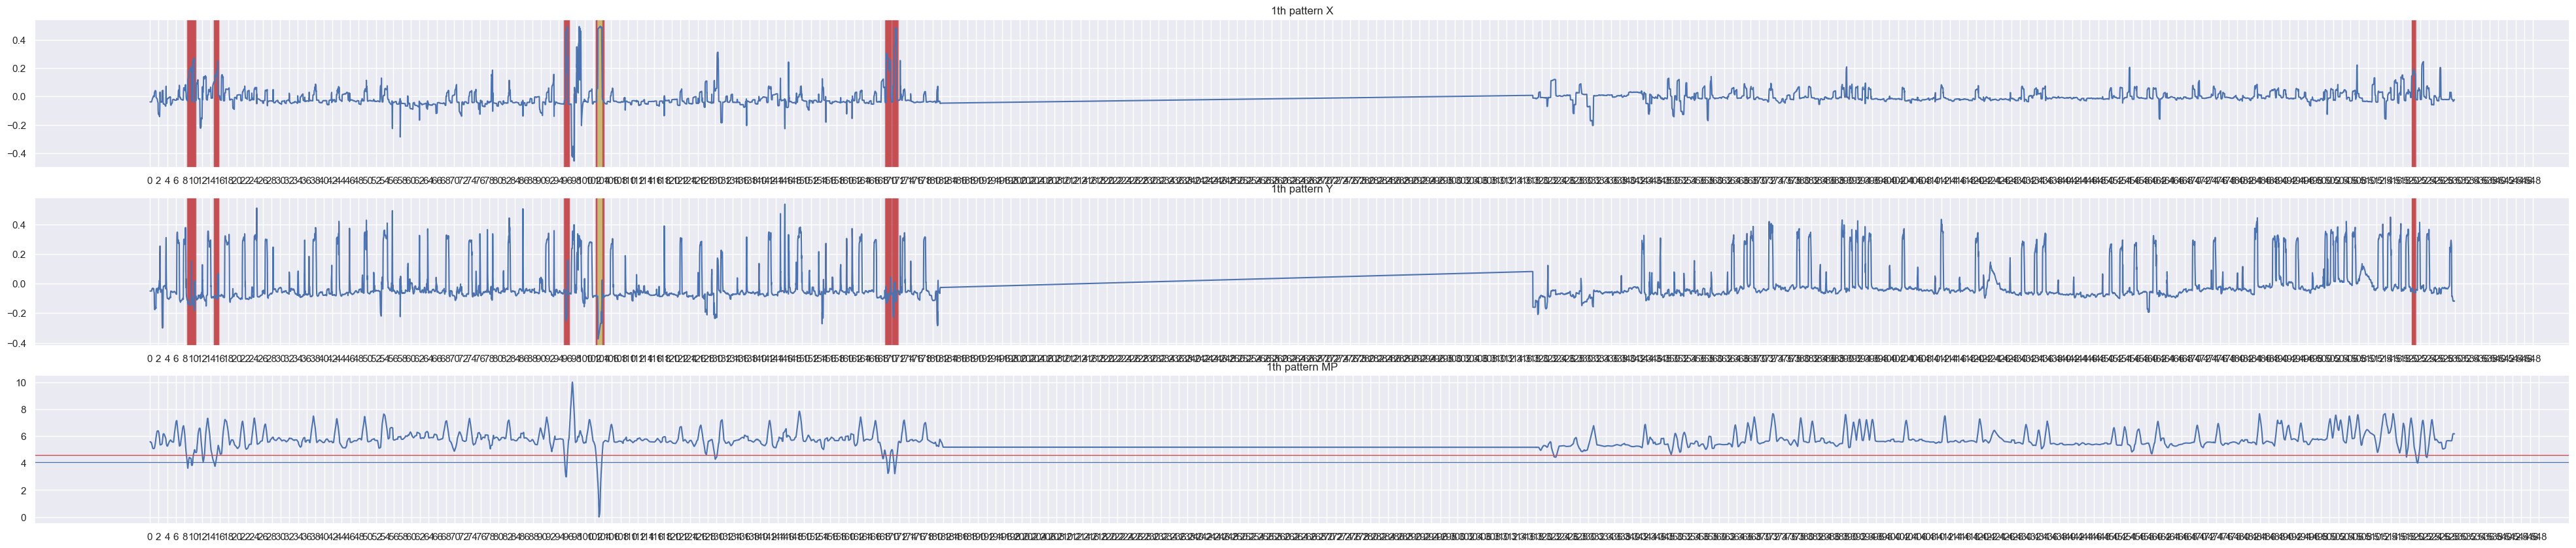

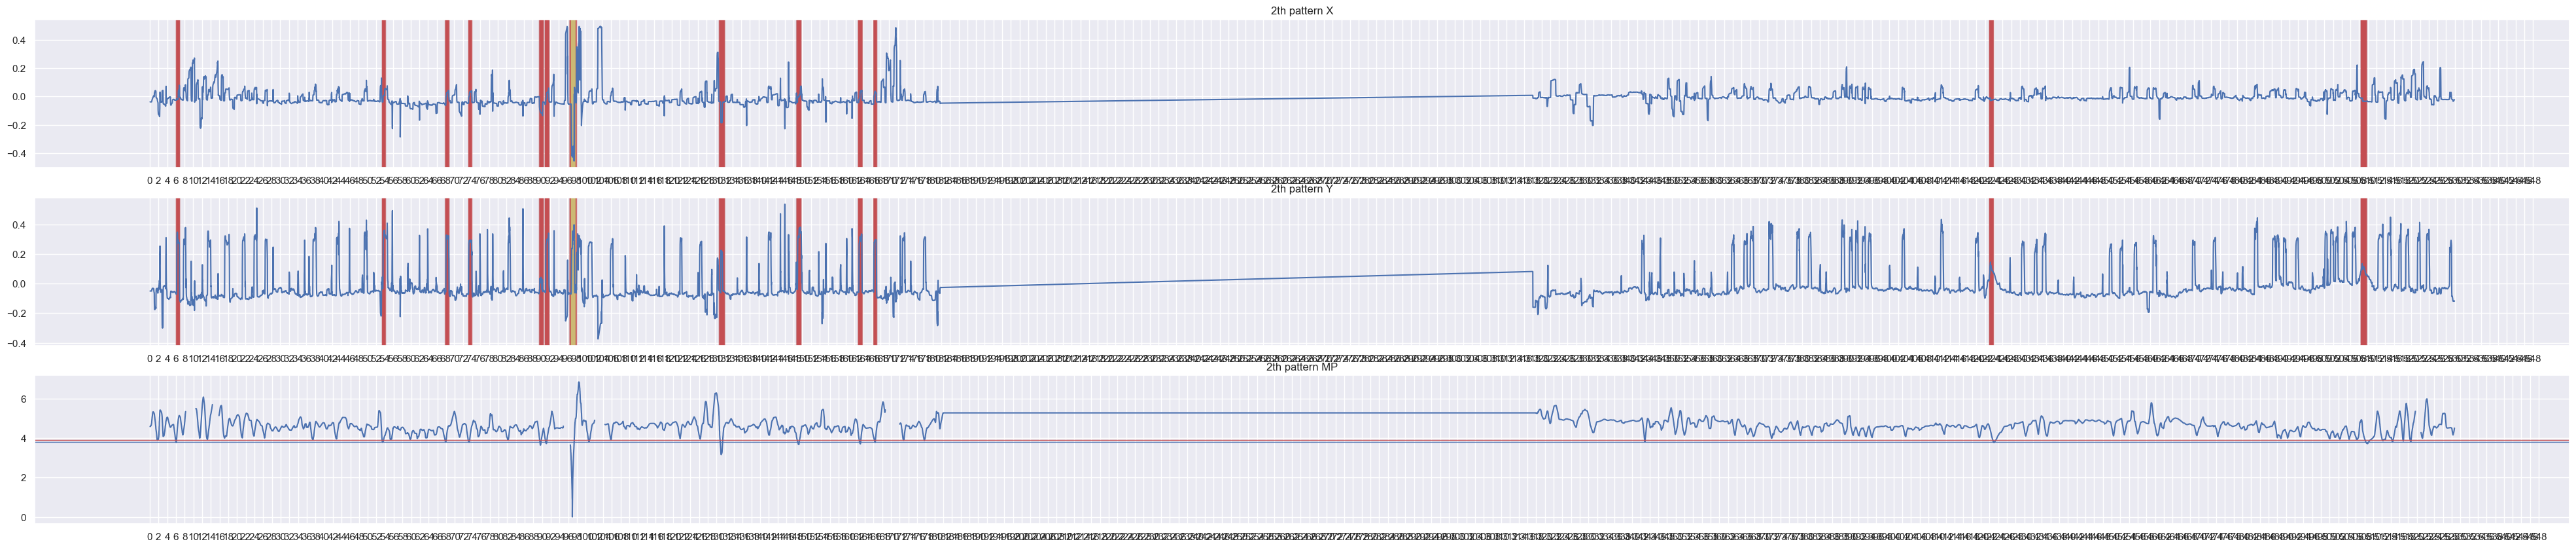

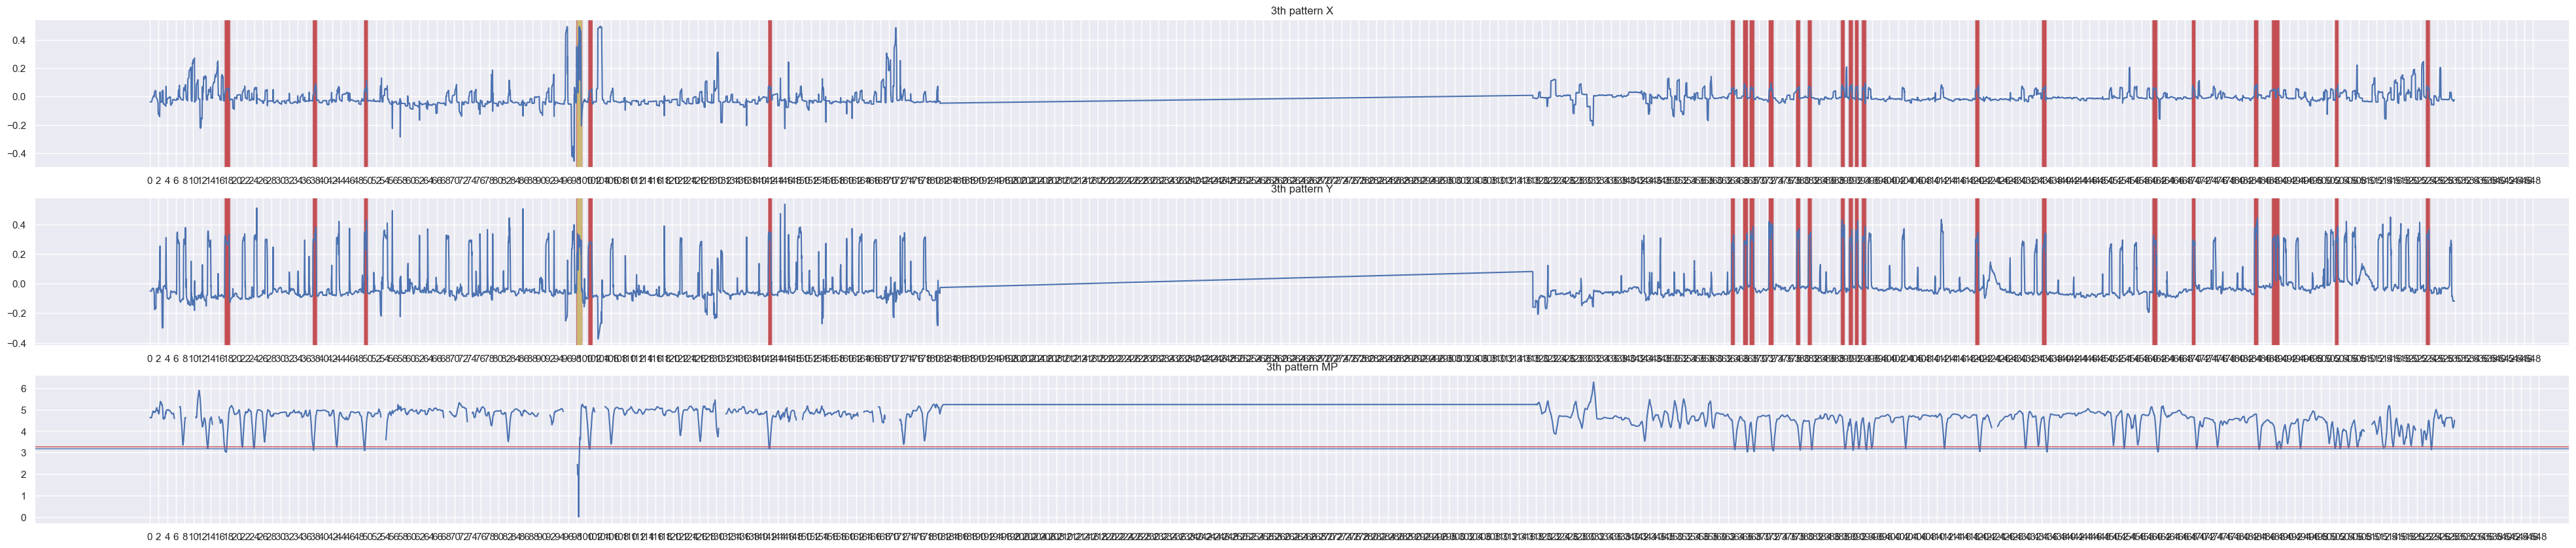

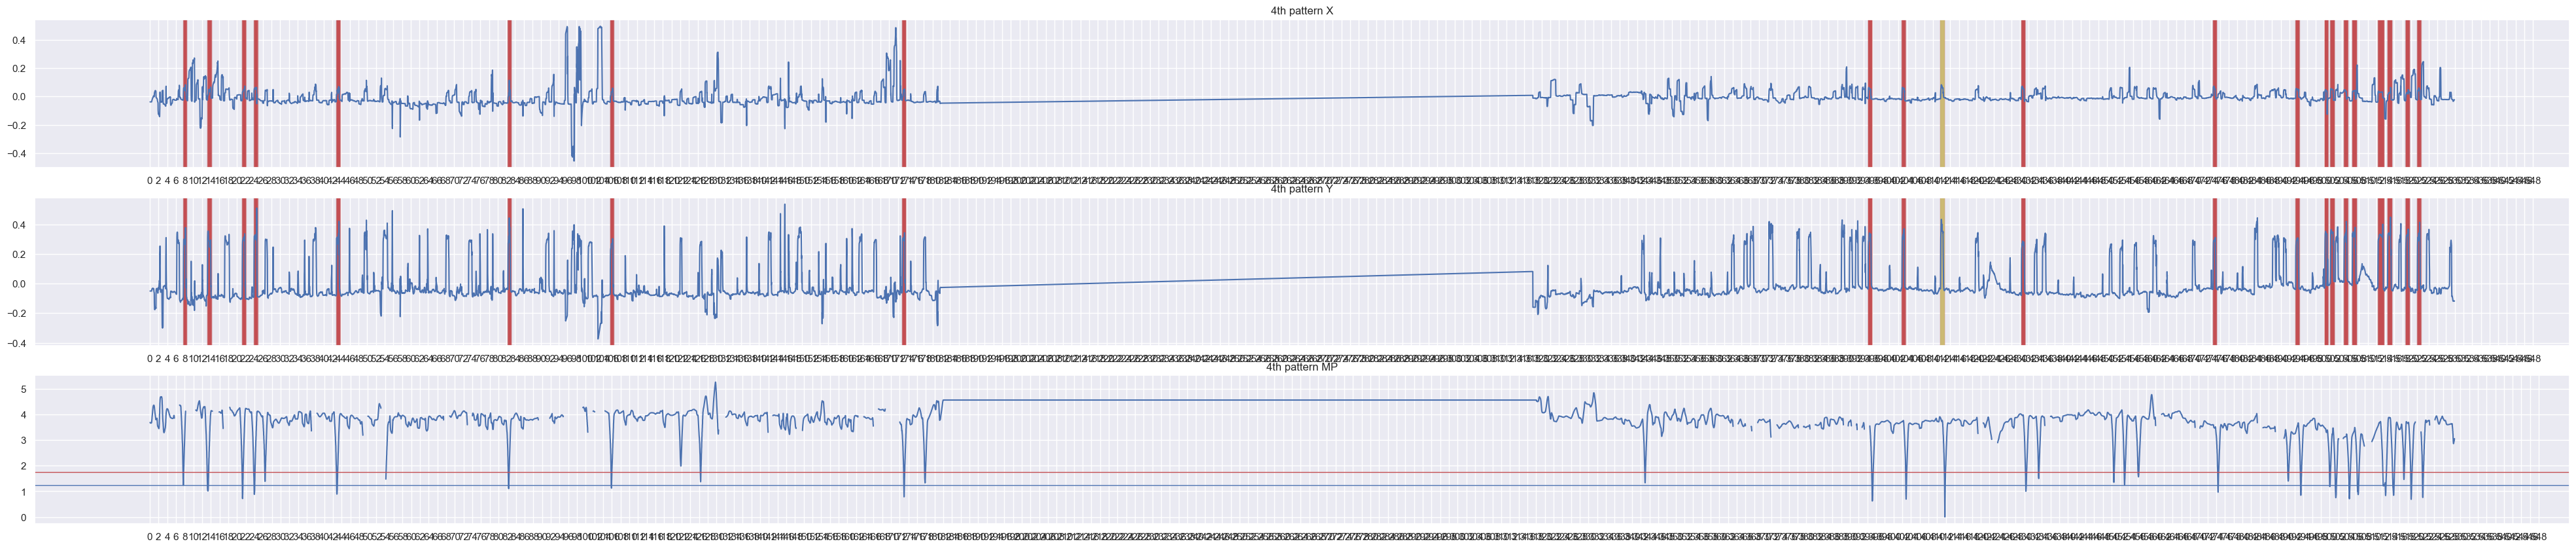

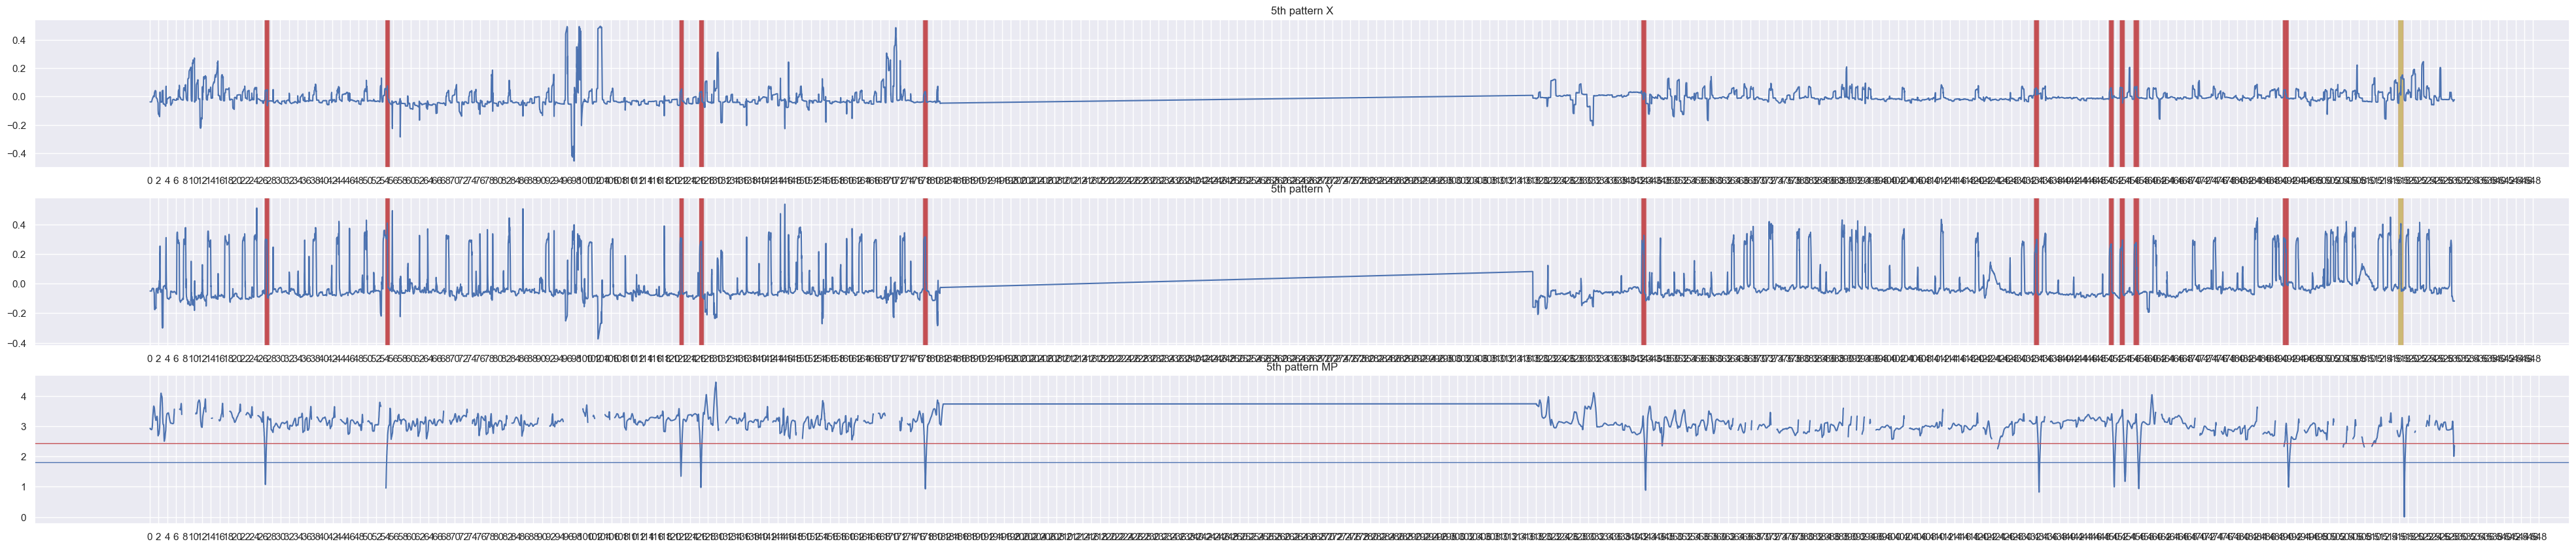

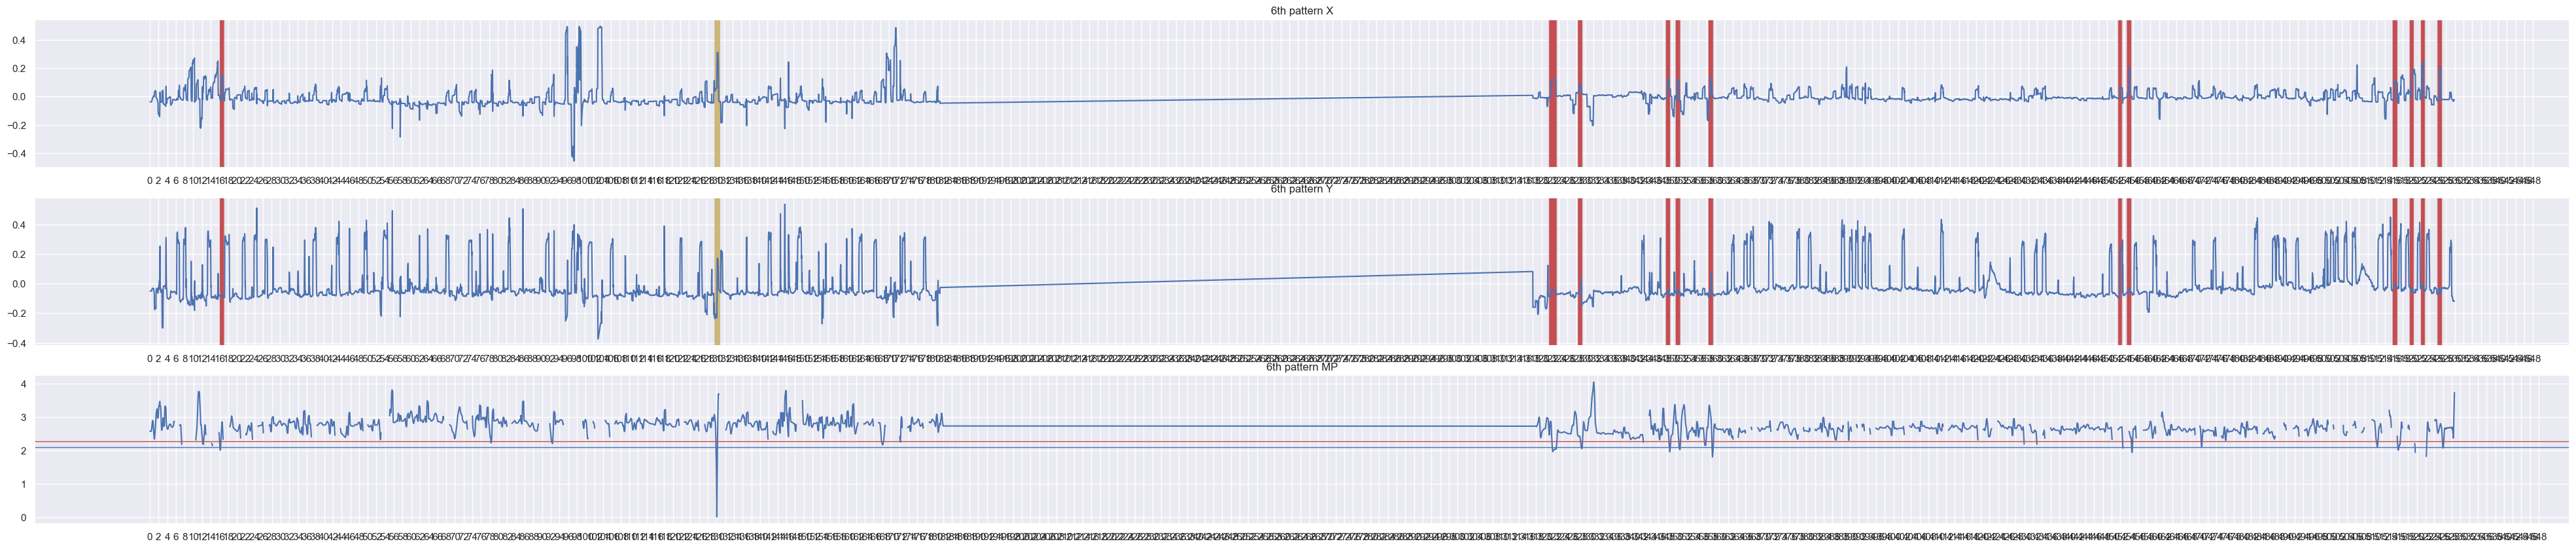

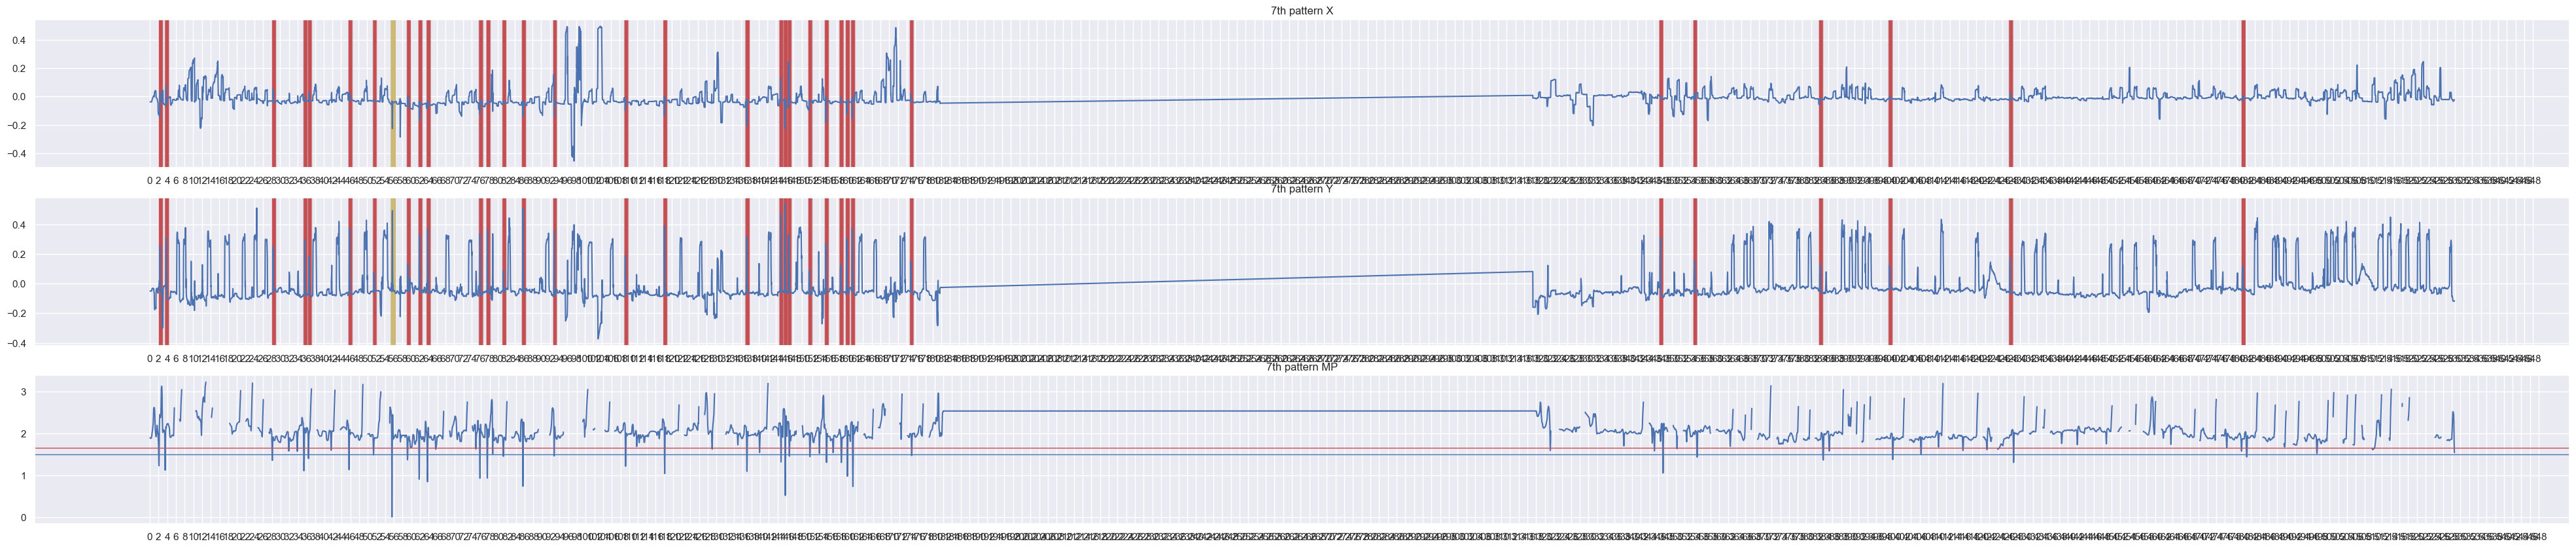

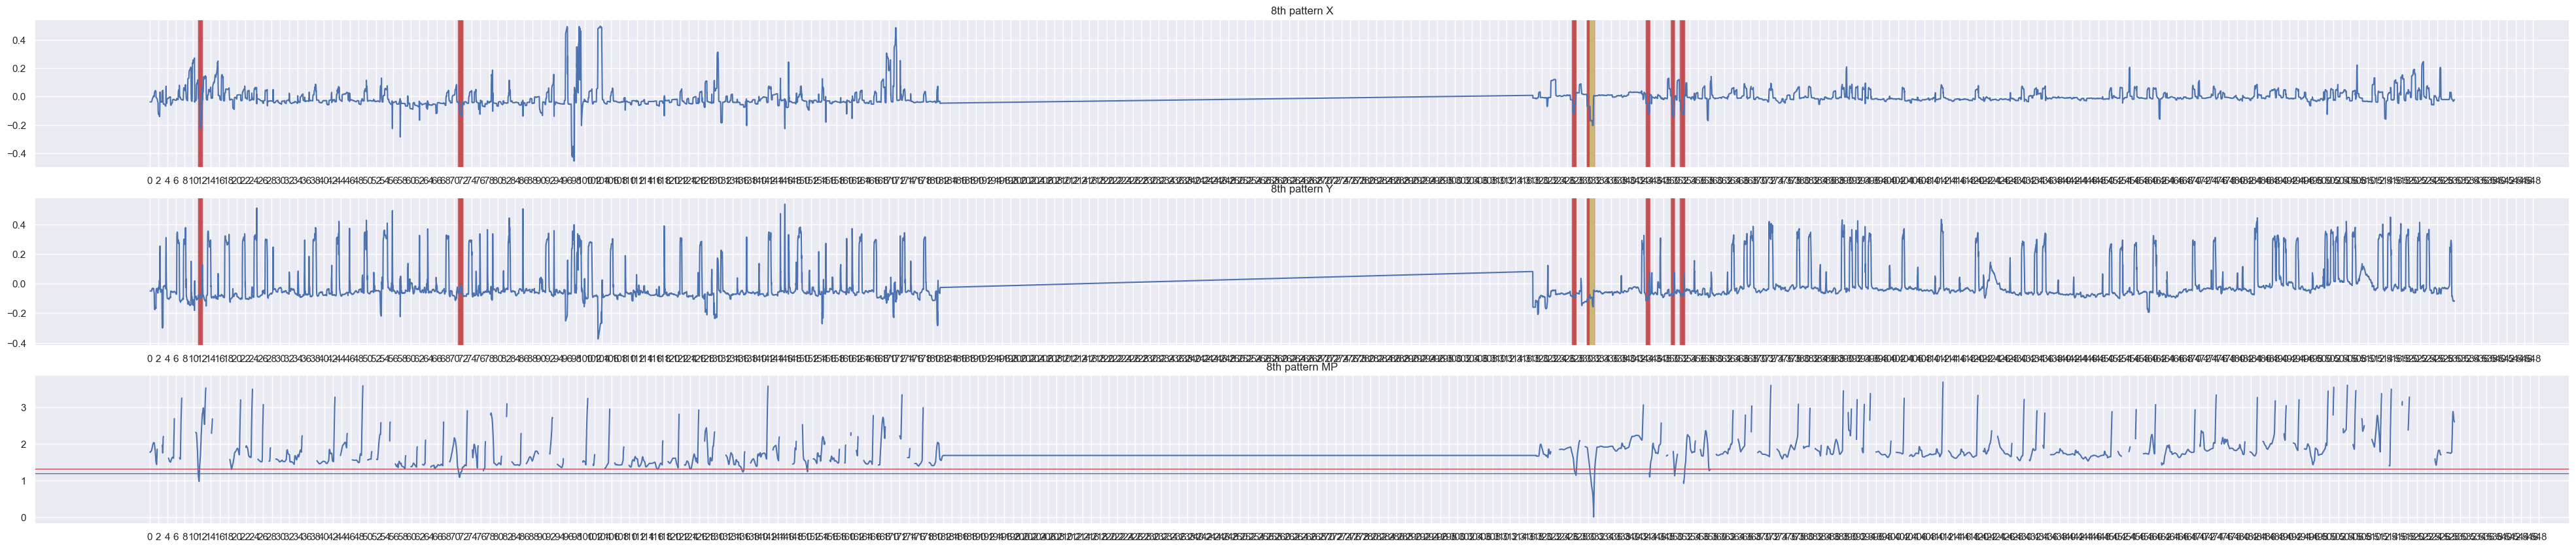

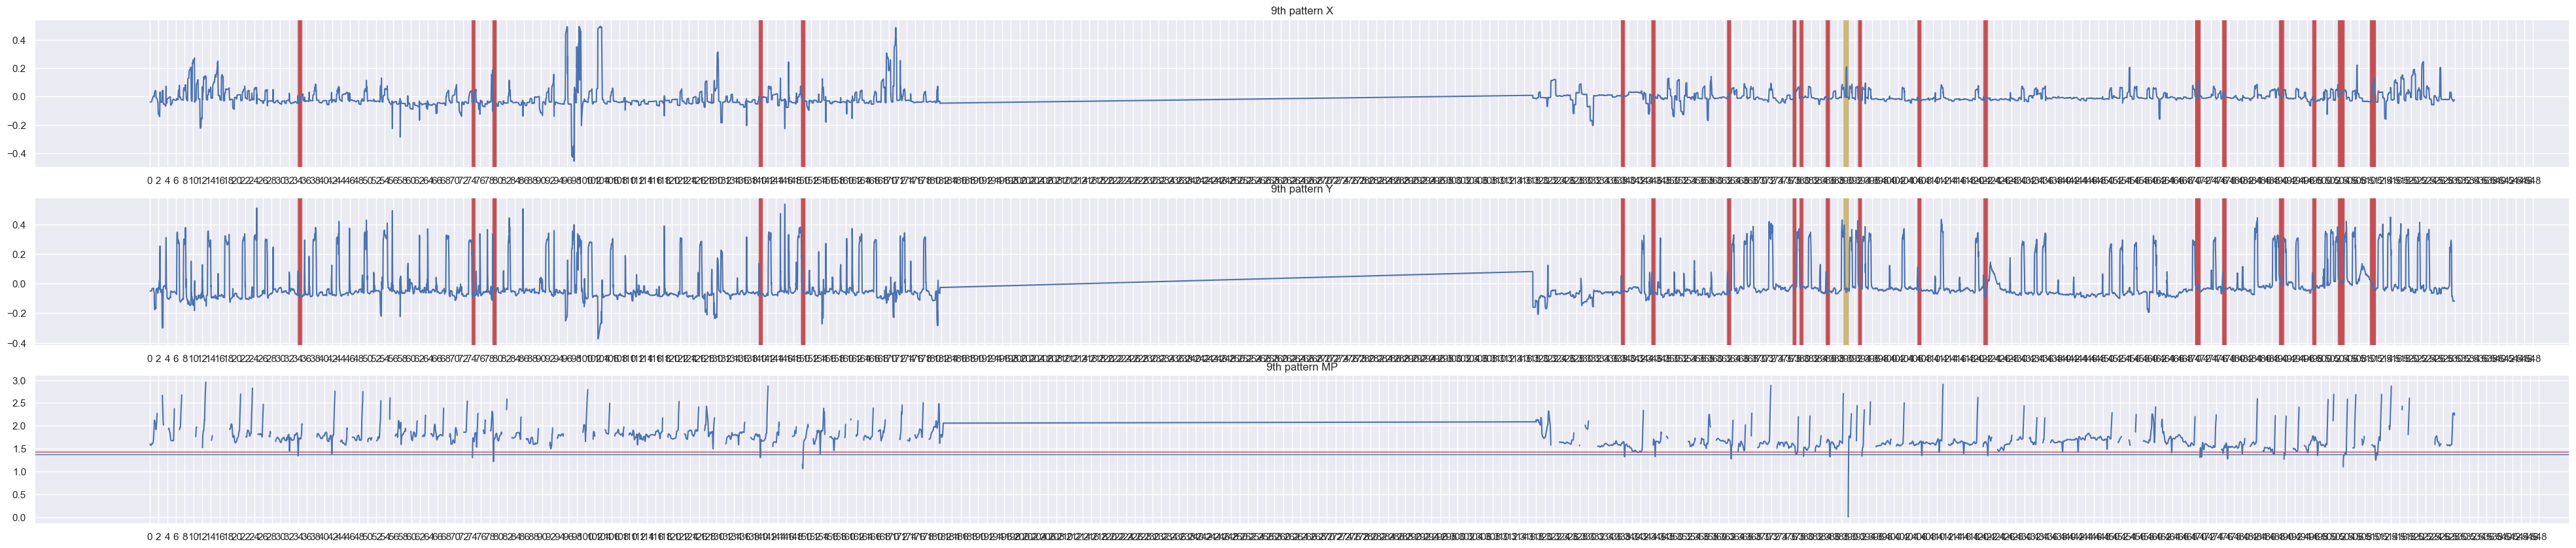

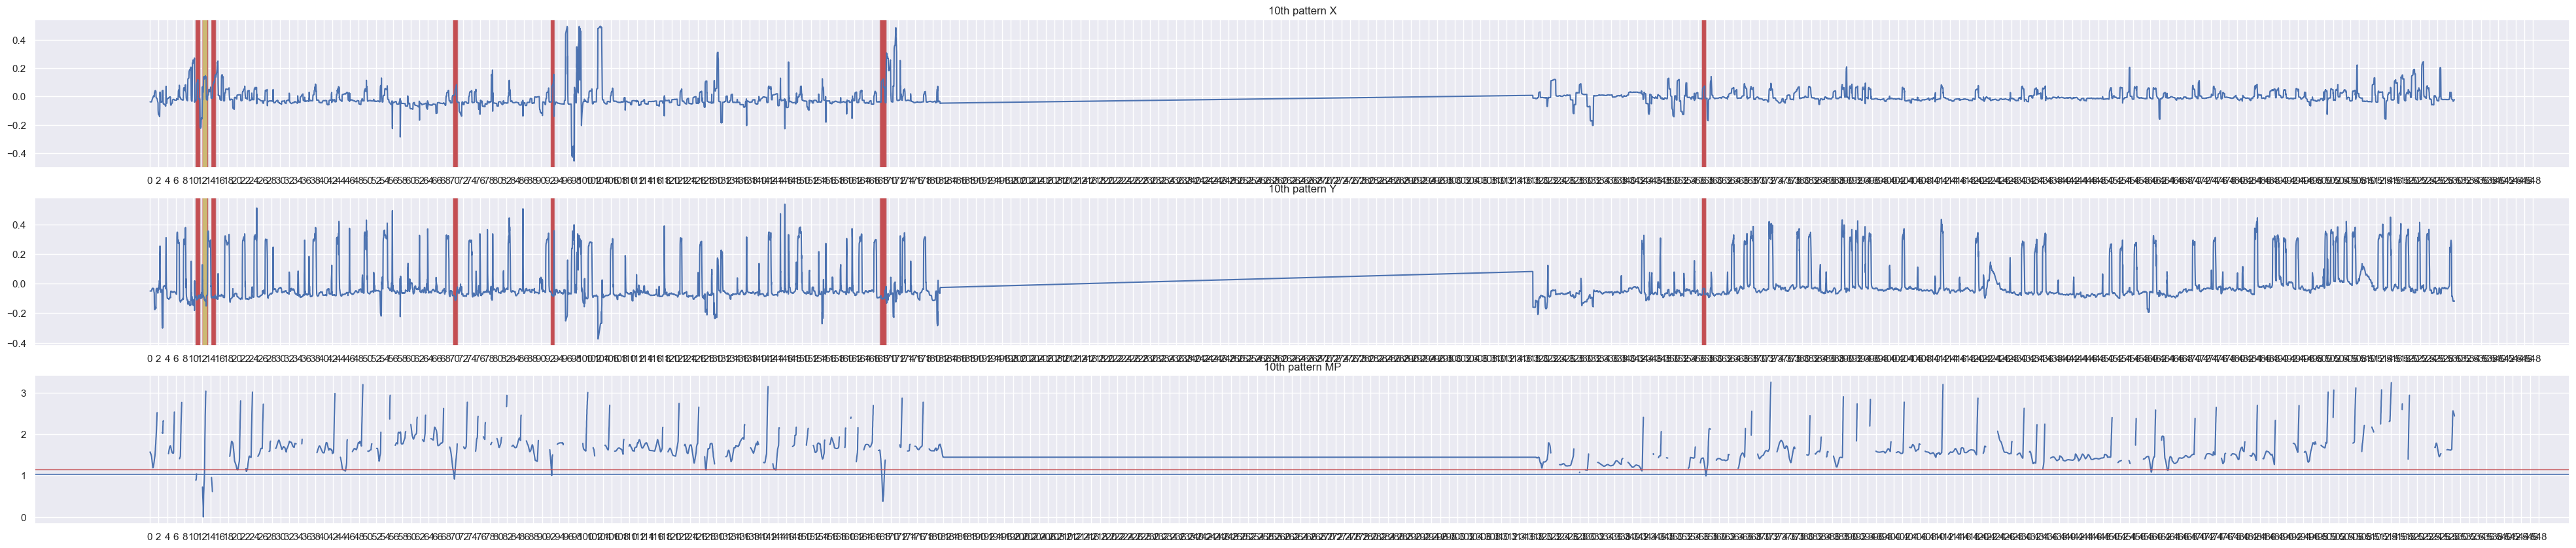

In [6]:
count = 0 # number of patterns

for i in range(k):

    profile_areas = np.nansum(D_plot, axis=1) # Calculates the sum of all non-NaN values in the array
    idx = np.where(profile_areas == max(profile_areas[profile_areas<np.inf]))[0][0] # np.inf: positive infinity
    
    mask_num = 1 # number of masks in one pattern
    prev_maskidx = None
    
    # count mask_num
    for maskidx in np.where(D_plot[idx]<=np.nanquantile(D_plot[idx],0.010))[0]:
        if prev_maskidx is None:
            prev_maskidx = maskidx
        elif maskidx - prev_maskidx > 1:
            mask_num += 1
            prev_maskidx = maskidx
        else:
            prev_maskidx = maskidx
    
    # if mask_num of a pattern < 5, set this "most unique" pattern to NA and move to loop
    if mask_num < 5:
        D_plot[np.array([np.max(mask[index:index+m])>=0 for index in indices]),:] = np.nan
        D_plot[:,np.isnan(Tx_process[:-m+1])] = np.nan
        D_plot[np.where(np.abs(indices - indices[idx])<int(m/2))[0],:] = np.nan
        continue
    
    snippets_x[count] = Tx[indices[idx] : indices[idx] + m]
    snippets_y[count] = Ty[indices[idx] : indices[idx] + m]
    snippets_aoi[count] = tempdf['aoi_idx'].iloc[indices[idx] : indices[idx] + m] 

    snippets_indices[count] = indices[idx]
    snippets_profiles[count] = D[idx]
    snippets_areas[count] = np.sum(D[idx])
    mask[indices[idx] : indices[idx] + m] = count
    
    for maskidx in np.where(D_plot[idx]<=np.nanquantile(D_plot[idx],0.010))[0]: # matrix profile
        mask[(maskidx) : (maskidx + m)] = count
        Tx_process[(maskidx - int(m/2)) : (maskidx + m)] = np.nan # remove Tx of the current pattern so that it does not affect the next pattern selection
        Ty_process[(maskidx - int(m/2)) : (maskidx + m)] = np.nan # remove Ty of the current pattern so that it does not affect the next pattern selection

    mask_list.append(np.append(np.where(D_plot[idx]<=np.nanquantile(D_plot[idx],0.010))[0],indices[idx]))
    
    sns.set(rc={'figure.figsize':(50,10)})
    fig, axs = plt.subplots(3)
    axs[0].set_title(f'{count+1}th pattern X')
    axs[1].set_title(f'{count+1}th pattern Y')
    axs[2].set_title(f'{count+1}th pattern MP')
    for t in tempdf['rec_time_s'].iloc[np.where(mask==count)[0]]:
        axs[0].axvline(t, color='r',ls='-',lw = 1, alpha = 0.1)
        axs[1].axvline(t, color='r',ls='-',lw = 1, alpha = 0.1)
    for t in tempdf['rec_time_s'].iloc[indices[idx]:(indices[idx]+m)]:
        axs[0].axvline(t, color='y',ls='-',lw = 1)
        axs[1].axvline(t, color='y',ls='-',lw = 1)
    axs[0].plot(tempdf['rec_time_s'], Tx)
    axs[1].plot(tempdf['rec_time_s'], Ty)
    axs[2].plot(tempdf['rec_time_s'].iloc[:-m+1], D_plot[idx,:])
    axs[2].axhline(np.nanquantile(D_plot[idx],0.025), color='r',ls='-',lw = 1)
    axs[2].axhline(np.nanquantile(D_plot[idx],0.010), color='b',ls='-',lw = 1)
    for ax in axs: ax.set_xticks(np.arange(0,550,2))
    plt.show()
    
    # post-processing to avoid situations where a similar pattern is selected in the next step
    D_plot[np.array([np.max(mask[index:index+m])>=0 for index in indices]),:] = np.nan
    D_plot[:,np.isnan(Tx_process[:-m+1])] = np.nan
    D_plot[np.where(np.abs(indices - indices[idx])<int(m/2))[0],:] = np.nan
    
    count += 1 # count new pattern

# we want k patterns as final result
if count < k:
    for i in range(count, k):
        profile_areas = np.nansum(D_plot, axis=1) # Calculates the sum of all non-NaN values in the array
        idx = np.where(profile_areas == max(profile_areas[profile_areas<np.inf]))[0][0] # np.inf: positive infinity
    
        snippets_x[count] = Tx[indices[idx] : indices[idx] + m]
        snippets_y[count] = Ty[indices[idx] : indices[idx] + m]
        snippets_aoi[count] = tempdf['aoi_idx'].iloc[indices[idx] : indices[idx] + m] 

        snippets_indices[count] = indices[idx]
        snippets_profiles[count] = D[idx]
        snippets_areas[count] = np.sum(D[idx])
        mask[indices[idx] : indices[idx] + m] = count
        mask_num = 1
        prev_maskidx = None
        for maskidx in np.where(D_plot[idx]<=np.nanquantile(D_plot[idx],0.010))[0]: # matrix profile
            if prev_maskidx is None:
                prev_maskidx = maskidx
            elif maskidx - prev_maskidx > 1:
                mask_num += 1
                prev_maskidx = maskidx
            else:
                prev_maskidx = maskidx
        print(mask_num)
        
        if mask_num < 5:
            D_plot[np.array([np.max(mask[index:index+m])>=0 for index in indices]),:] = np.nan
            D_plot[:,np.isnan(Tx_process[:-m+1])] = np.nan
            D_plot[np.where(np.abs(indices - indices[idx])<int(m/2))[0],:] = np.nan
            continue
    
        for maskidx in np.where(D_plot[idx]<=np.nanquantile(D_plot[idx],0.010))[0]: # matrix profile
            mask[(maskidx) : (maskidx + m)] = count
            Tx_process[(maskidx - int(m/2)) : (maskidx + m)] = np.nan # remove Tx of the current pattern so that it does not affect the next pattern selection
            Ty_process[(maskidx - int(m/2)) : (maskidx + m)] = np.nan # remove Ty of the current pattern so that it does not affect the next pattern selection

        mask_list.append(np.append(np.where(D_plot[idx]<=np.nanquantile(D_plot[idx],0.010))[0],indices[idx]))
    
        sns.set(rc={'figure.figsize':(50,10)})
        fig, axs = plt.subplots(3)
        axs[0].set_title(f'{count+1}th pattern X')
        axs[1].set_title(f'{count+1}th pattern Y')
        axs[2].set_title(f'{count+1}th pattern MP')
        for t in tempdf['rec_time_s'].iloc[np.where(mask==count)[0]]:
            axs[0].axvline(t, color='r',ls='-',lw = 1, alpha = 0.1)
            axs[1].axvline(t, color='r',ls='-',lw = 1, alpha = 0.1)
        for t in tempdf['rec_time_s'].iloc[indices[idx]:(indices[idx]+m)]:
            axs[0].axvline(t, color='y',ls='-',lw = 1)
            axs[1].axvline(t, color='y',ls='-',lw = 1)
        axs[0].plot(tempdf['rec_time_s'], Tx)
        axs[1].plot(tempdf['rec_time_s'], Ty)
        axs[2].plot(tempdf['rec_time_s'].iloc[:-m+1], D_plot[idx,:])
        axs[2].axhline(np.nanquantile(D_plot[idx],0.025), color='r',ls='-',lw = 1)
        axs[2].axhline(np.nanquantile(D_plot[idx],0.010), color='b',ls='-',lw = 1)

        for ax in axs: ax.set_xticks(np.arange(0,550,2))
        plt.show()
    
    # post-processing to avoid situations where a similar pattern is selected in the next step
        D_plot[np.array([np.max(mask[index:index+m])>=0 for index in indices]),:] = np.nan
        D_plot[:,np.isnan(Tx_process[:-m+1])] = np.nan
        D_plot[np.where(np.abs(indices - indices[idx])<int(m/2))[0],:] = np.nan

        count += 1
        
plt.show()